In [1]:
%matplotlib notebook

import numpy as np
import itertools
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import mdtraj as md
#import skbeam.core.roi as roi
import skbeam.core.utils as utils

import sys
sys.path.insert(0, 'scripts/')
from functions import display_2d
from integrators import *

sns.set_context('notebook')
plt.rcParams['image.cmap'] = 'inferno'

# Setup

## Cromer-Mann parameters

Import Cromer-Mann parameters in a panda dataframe.

In [2]:
cromer_mann_pars = pd.read_pickle('./source/atomic-formfactors.pkl')

## Import coordinates

In [3]:
!ls source

1AKI.pdb               1AKI_solv_small2.pdb   gromacs-Iq-lys.xvg
1AKI_clean.pdb         3rgk.pdb               protein_OW.pdb
1AKI_solv.gro          atomic-formfactors.pkl water.pdb
1AKI_solv.pdb          crystal.pdb
1AKI_solv_small.pdb    crystal_16.pdb


In [4]:
pdbfile='source/1AKI.pdb' # structure file with all the coordinates of the atoms
name = pdbfile[7:-4] # used just to rename the plot saved
traj=md.load_pdb(pdbfile)
traj

<mdtraj.Trajectory with 1 frames, 1001 atoms, 129 residues, and unitcells at 0x7fe0eca130a0>

In [5]:
coord = traj.xyz[0]*10 # 0 is the number of frames. Multiplied by 10 to change the units from nm to Å
coord = coord.T
print(type(coord))
print(coord.shape)

<class 'numpy.ndarray'>
(3, 1001)


In [6]:
topology = traj.topology
topology

<mdtraj.Topology with 1 chains, 129 residues, 1001 atoms, 1025 bonds at 0x7fe0e88628e0>

Display all the atom positions in a 3D plot.

In [7]:
fig = plt.figure(figsize=[5,4]) 
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax1.scatter(*coord, c='red')
ax1.set_xlabel('x (Å)')
ax1.set_ylabel('y (Å)')
ax1.set_zlabel('z (Å)')
ax1.set_title('atom positions');

<IPython.core.display.Javascript object>

# Molecular form factor

## Functions

**Atomic form factor**

In [8]:
def atomic_formfactor(q, element):
    """Calculate the atomic formfactor approximation.
    
    Args:
        q (np.ndarray): array of momentum transfers in inverse angstrom.
        element (str): name of the element from the database. 
        
    Returns:
        Atomic formfactor.
        
    """
    a = cromer_mann_pars.loc[element, [f"a{i}" for i in range(1,5)]]
    b = cromer_mann_pars.loc[element, [f"b{i}" for i in range(1,5)]]
    c = cromer_mann_pars.loc[element, 'c']
    
    a = np.asarray(a)
    b = np.asarray(b)
    c = float(c)
    
    assert len(a) == len(b) == 4
    
    def single_q(q):
        # formula for the Cromer-Mann formfactor
        f = np.sum( a * np.exp( -b * q**2 ),axis=-1) + c
        return f
    
    return np.vectorize(single_q)(q)

**Molecular form factor**

In [9]:
def mol_formfactor(q, traj, xyz):
    
    n_atoms = xyz.shape[1] #traj.n_atoms
    topology = traj.topology
    
    q_norm = np.linalg.norm(q, axis=0)    
    f = 0
    
    for atom_idx  in range(n_atoms):
        
        atom = topology.atom(atom_idx)
        element = atom.element.symbol
    
        dp = q.T @ xyz[:,atom_idx]  # q*r matrix-product: (n_pixel, n_pixel, n_atoms)
        f += atomic_ff[element] * np.exp(dp*1j)  #  (n_pixel, n_pixel)

    return np.abs(f)

## Calculations

Define the geometry of the experiment.

In [10]:
n_pix = 201  # number of detector pixels along each dimension
dd = 200 # sample-detector distance in units of pixel size
k_out = np.zeros((3, n_pix, n_pix))  # initialize the scatterd wave vectors
wavelenght = 1.  # in angstrom

# wavevector of incident radiation: direction of the incoming X-ray along y axis
k_in = np.array([0,1,0])

# wavevector of scattered radiation
k_out[1] = dd
ind = np.arange(n_pix) - n_pix/2 
ind = np.meshgrid(ind, ind)
k_out[[0,2]] = ind
k_out /= np.linalg.norm(k_out, axis=0)

# momentum transfer
q = (k_in[:,None,None] - k_out) * 2.*np.pi / wavelenght

# absolute momentum transfer
q_norm = np.linalg.norm(q, axis=0) 

# example of atomic form factor of oxygen
f_atom_2d = atomic_formfactor(q_norm, 'O')

# plot the q-map and the atomic form factor
fig, (ax1, ax2) = plt.subplots(1,2,figsize=[8,3], constrained_layout=True)
display_2d(q_norm, title = 'q map', ax=ax1, ylabel=r'z')#,vmin=5.9, vmax=5.94)
display_2d(f_atom_2d, title = 'form factor O', ax=ax2, 
           extent=[q[0].min(), q[0].max()]*2, xlabel=r'$q_x$', ylabel=r'$q_z$');
#plt.savefig(f'plots/{name}_qmap.png', dpi=200)

<IPython.core.display.Javascript object>

Define a dictionary to save the atomic form factors needed for the system chosen (lysozyme and water). The elements needed are:
* C = 613
* N = 193
* O = 185
* S = 10

In [11]:
# dictionary with atomic form factors needed
atomic_ff = {}
for ele in "C O N S Fe H".split():
    atomic_ff[ele] = atomic_formfactor(q_norm, ele)

# Calculate and display the molecular form factor

In [12]:
mol_ff_one = mol_formfactor(q, traj, coord) # 'one' stands for one orientation
intensity_one = mol_ff_one**2
intensity_one.shape

(201, 201)

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=[8,3], constrained_layout=True)
display_2d(mol_ff_one, title='molecular form factor', ax=ax1,norm=LogNorm(vmin=None, vmax=None), colorbar=True)
display_2d(intensity_one, title='intensity', ax=ax2, colorbar=True, norm=LogNorm(vmin=1e1, vmax=1e5))
fig.suptitle('single orientation')
#plt.savefig(f'/Users/maddalena/Documents/01-SU/courses/21-modern-x-ray-science/project/plots/{name}_2d-patt.png', dpi=200)
plt.show()

<IPython.core.display.Javascript object>

## Rotations

Funciton to rotate the system along the Fibonacci spiral. It provides N different orientations.

In [14]:
def rotations(coord,N=5):
    rotateds = []
    for j in range(N):

        # define phi
        phi=(1 + np.sqrt(5))*j*np.pi

        # define theta
        d=1-2*j/N
        theta=np.arccos(d)

        # rotation matrix: around x axis
        C = np.cos
        S = np.sin
        Rx = np.array([
            [1,0,0],
            [0,C(phi),-S(phi)],
            [0,S(phi),C(phi)],
        ])
        # new coordinates saved in rotated matrix
        rotated = Rx@coord

        # second rotation: around y axis
        Ry = np.array([
            [C(theta),0,S(theta)],
            [0,1,0],
            [-S(theta),0,C(theta)],
        ])
        # update coordinate
        rotated = Ry@rotated
        # list with all coordinates: shape (N+1,3,n_atom))
        rotateds.append(rotated)
        
    return rotateds


The following function is just to save the values of the angles phi and theta.

In [15]:
# just to save the angle values
def angles(N=5):
    rotateds = []
    phis, thetas = [], []
    
    for j in range(N):

        # define phi
        phi=(1 + np.sqrt(5))*j*np.pi
        phis.append(phi)
        
        # define theta
        d=1-2*j/N
        acos=np.arccos(d)
        theta=acos#*180/np.pi
        thetas.append(theta)
        print(j, phi, theta)
        
    return phis, thetas

In [16]:
phis, thetas = angles(10)

0 0.0 0.0
1 10.166407384630519 0.6435011087932843
2 20.332814769261038 0.9272952180016123
3 30.49922215389156 1.1592794807274085
4 40.665629538522076 1.369438406004566
5 50.8320369231526 1.5707963267948966
6 60.99844430778312 1.7721542475852272
7 71.16485169241363 1.9823131728623844
8 81.33125907704415 2.2142974355881813
9 91.49766646167468 2.498091544796509


### Calculate Molecular form factor for different orientations

In [17]:
N=10
# coordinates of different orientations
xyzs = rotations(coord, N)

mol_ff=0
mol_ff_sep = np.zeros(shape=(N, n_pix, n_pix))
for i in range(N):
    print("calculating Molecular Form factor of rotation ", i)
    mol_ff_sep[i,:,:] = mol_formfactor(q, traj, xyzs[i])
    mol_ff += mol_ff_sep[i,:,:]
    
mol_ff /= N # normalization

0
1
2
3
4
5
6
7
8
9


In [18]:
# calculate intensity by square
intensity = mol_ff**2 # averaged scattering pattern
intensity_sep = mol_ff_sep**2 # here the N scattering patterns from the different conformations are saved
intensity_sep.shape

(10, 201, 201)

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=[8,3], constrained_layout=True)
im1 = ax1.imshow(mol_ff,norm=LogNorm(vmin=1e0, vmax=1e4))
ax1.set_title('molecular form factor')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(intensity,norm=LogNorm(vmin=1e1, vmax=1e6))
ax2.set_title('intensity')
plt.colorbar(im2, ax=ax2)

fig.suptitle(f'average of {N} orientations ')
#plt.savefig(f'/Users/maddalena/Documents/{name}_2d-patt-No.png', dpi=200)
plt.show()

<IPython.core.display.Javascript object>

Plot the different scattering patterns.

In [20]:
nrow, ncol = 2,5
fig, ax = plt.subplots(nrow,ncol,figsize=[8,4], constrained_layout=True)
counter = 0
for i in range(nrow):
    for j in range(ncol):
        if counter < 10:
            im = ax[i,j].imshow(intensity_sep[counter,:,:], norm=LogNorm(vmin=1e1, vmax=1e4))
            ax[i,j].axis('off')
            ax[i,j].set_title(f'$\phi$={phis[counter]:.0f}, $\\theta$={thetas[counter]:.0f}')
            counter += 1
fig.suptitle(f'scattering patterns of {N} different orientations')
plt.show()

<IPython.core.display.Javascript object>

# Angular integration

## I(Q) calc

**First way for calculating the azimuthal integrated scattering intensity**

In [21]:
def I_integr(q_norm, n_pix, intensity):
    bins = np.linspace(0.,np.max(q_norm), n_pix//4)
    I = np.zeros(bins.shape)
    num = np.zeros(bins.shape)
    Q = q_norm.ravel()
    Fsim = intensity.ravel()

    for idx in range(Q.shape[0]):
        pos = np.argmin(np.abs(Q[idx] - bins))
        I[pos] = I[pos] + Fsim[idx]
        num[pos] = num[pos]+1

    I = I/num
    #I = I*np.exp(-bins**2.*0.05) # % Include Experimental Debye Factor 79. %plot(bins,I./max(I (bins>1)),'-b','linewidth',1.5)

    return bins, I
q_new, I_new = I_integr(q_norm, n_pix, intensity)

**Second method to compute the azimuthal integrated scattering intensity**

In [22]:
# -- angular integration parameters
n_bins = 100        # number of bins (integration ring thickness)
min_x,max_x = 0,100  # n_bins
mask_thr = 0         # threshold limit for integrator
cx, cy = int(n_pix/2), int(n_pix/2)

# angular integration
qbin, Iq_ff1 = angular_average(mol_ff_one, (cx,cy), mask=None, threshold=mask_thr, nx=n_bins, min_x=None, max_x=None)
qbin, Iq_ff = angular_average(mol_ff, (cx,cy), mask=None, threshold=mask_thr, nx=n_bins, min_x=None, max_x=None)

qbin, Iq_int1 = angular_average(intensity_one, (cx,cy), mask=None, threshold=mask_thr, nx=n_bins, min_x=None, max_x=None)
qbin, Iq_int = angular_average(intensity, (cx,cy), mask=None, threshold=mask_thr, nx=n_bins, min_x=None, max_x=None)

# x-ray parameters
h = 4.135667516*1e-18   # keV*sec
c = 3*1e8               # m/s
#wavelength = 1          # Å-1
energy = h*c/(wavelenght*1e-10)

# detector params
dpix = 1    # physical size of the pixels
Ldet = dd   # detector-sample distance

qt =[]
for i in np.arange(len(qbin)):
    inner_radius = qbin[i]
    width = 0
    spacing = 0
    num_rings = 1
    
    edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
    
    two_theta = utils.radius_to_twotheta(Ldet, edges*dpix)
    q_val = utils.twotheta_to_q(two_theta, wavelenght)
    qt.extend(np.mean(q_val, axis=1))

qbin_max = qbin[-1]

In [23]:
intensity.shape

(201, 201)

In [24]:
# compute Iq and then average them
Iq_ = np.zeros(shape=(N, len(qt)))
for i in range(N):
    qbin, Iq_[i] = angular_average(intensity_sep[i,:,:], (cx,cy), mask=None, threshold=mask_thr, nx=n_bins, min_x=None, max_x=None)

In [25]:
Iq_avg = np.average(Iq_, axis=0)

## Plot the angular integration

In [26]:
plt.figure(figsize=(5,4))
plt.plot(qt, Iq_int1, label='2nd method: single orient')
plt.plot(qt, Iq_int, label='2nd method: many orients')
plt.plot(q_new, I_new, label='1st method: many orients')
#plt.yscale('log')
plt.legend()
plt.xlim(0.5,3)
plt.ylim(0,4e3)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


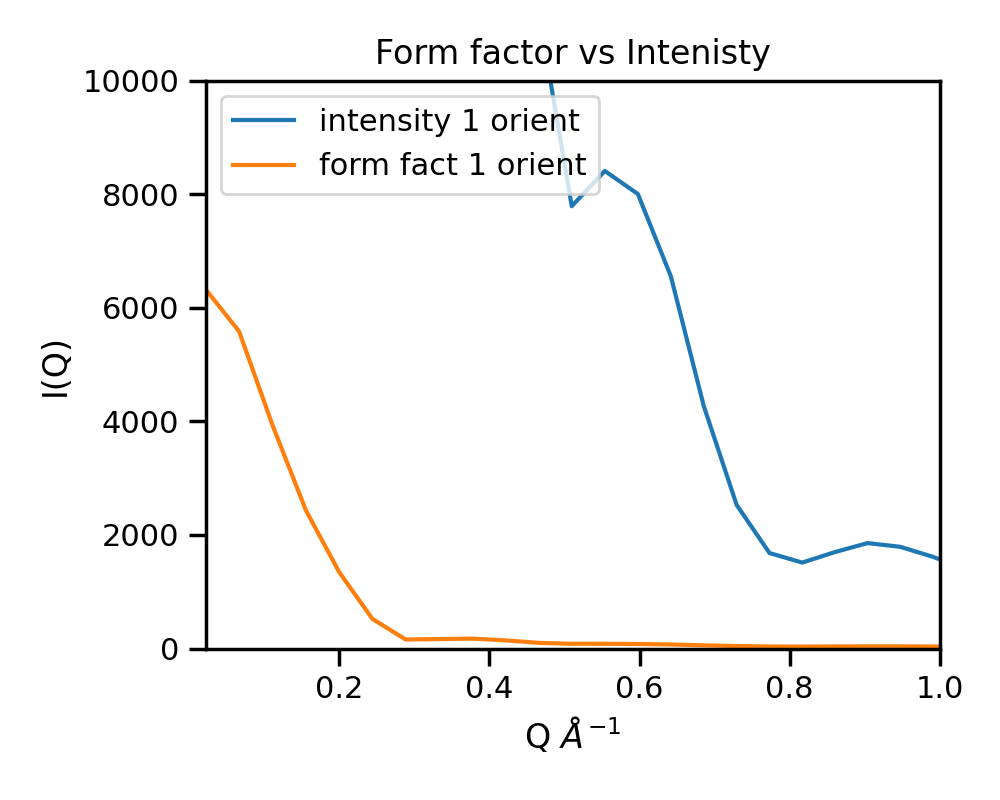

In [31]:
plt.figure(figsize=(5,4))
plt.plot(qt, Iq_int1, label='intensity 1 orient')
plt.plot(qt, Iq_ff1, label='form fact 1 orient')

#plt.plot(qt, Iq_int, label='orientations')
#plt.plot(qt, Iq_ff, label='ff orientations')

#plt.plot(qt, Iq_[0], label='0', ls='--')
#plt.plot(qt, Iq_[1], label='1', ls='--')
#plt.plot(qt, np.average(Iq_, axis=0), 'k-', label='avg')
plt.title('Form factor vs Intenisty')
plt.xlabel('Q $\AA^{-1}$')
plt.ylabel('I(Q)')
plt.ylim(0,1e4)
plt.xlim(qt[0],1.)
#plt.yscale('log')
plt.legend()
plt.tight_layout()
#plt.savefig(f'/Users/maddalena/Documents/01-SU/courses/21-modern-x-ray-science/project/plots/{name}_Iq.png', dpi=200)
plt.show()

<IPython.core.display.Javascript object>


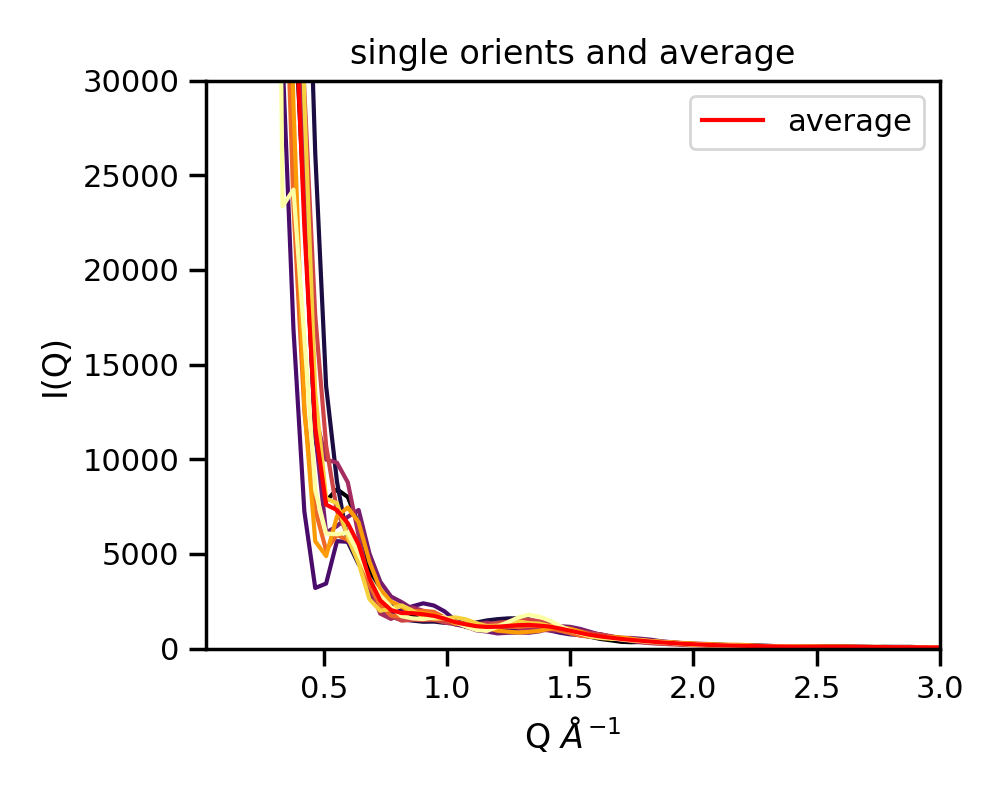

In [32]:
plt.figure(figsize=(5,4))

col = plt.cm.inferno(np.linspace(0,1,N))
for i in range(N):
    plt.plot(qt, Iq_[i], c=col[i])
plt.plot(qt, np.average(Iq_, axis=0), 'r-', label='average')

plt.title('single orients and average')
plt.xlabel('Q $\AA^{-1}$')
plt.ylabel('I(Q)')
plt.ylim(0,3e4)
plt.xlim(qt[0],3.)
#plt.yscale('log')
plt.legend()
plt.tight_layout()
#plt.savefig(f'/Users/maddalena/Documents/{name}_Iqs.png', dpi=200)
plt.show()

# Save data

In [33]:
!pwd

/Users/maddalena/Documents/01-SU/courses/21-modern-x-ray-science/project


In [34]:
# define the directory to save the data
f = f'/Users/maddalena/Documents/01-SU/courses/21-modern-x-ray-science/project/results/{name}'

np.save(f+'_q.npy', qt)
np.save(f+'_Iq_avg_pat.npy', Iq_int)

np.save(f+'_Iqs.npy', Iq_)
np.save(f+'_Iq_avg.npy', Iq_avg)

# 2d patterns: all orientantions
np.save(f+'_2d_int.npy', intensity)
np.save(f+'_mol_ff.npy', mol_ff)
np.save(f+'_2ds_int.npy', intensity_sep)
